### Libraries Import

In [1]:
# Importa todas as bibliotecas
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import os
import nrrd
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import (
    Input, Conv3D, MaxPooling3D, Concatenate, Add, ReLU,
    BatchNormalization,GlobalAveragePooling1D, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Reshape, AveragePooling3D
)
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

### Aux. Functions

In [2]:
def load_data(image_dir, mask_dir):
    """
    Encontra e pareia os caminhos das imagens com suas 
    respectivas máscaras de segmentação.
    """
    file_list = []

    # Garante que os arquivos estão ordenados para o pareamento correto
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for image_file, mask_file in zip(image_files, mask_files):
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        if os.path.exists(mask_path):
            # Ler a máscara para determinar o rótulo
            mask_itk = sitk.ReadImage(mask_path)
            mask_np = sitk.GetArrayFromImage(mask_itk)
            
            # O rótulo é 1 se houver qualquer pixel não-zero na máscara, senão 0
            label = 1 if np.sum(mask_np) > 0 else 0
            
            file_list.append({
                "image": image_path,
                "mask": mask_path,
                "label": label
            })
        else:
            print(f"Aviso: Máscara não encontrada para {image_path}")
            
    return file_list

def load_data_OpenNeuro(image_dir, file_list):
    """
    Encontra e pareia os caminhos das imagens com suas 
    respectivas máscaras de segmentação.
    """

    # Garante que os arquivos estão ordenados para o pareamento correto
    image_files = sorted(os.listdir(image_dir))

    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
            
        file_list.append({
            "image": image_path,
            "mask": None,
            "label": 0
        })
            
    return file_list

In [3]:
def build_cnn_encoder(input_shape=(140, 140, 140, 2)):
    inputs = Input(shape=input_shape)
    
    # ... Camadas Convolucionais ...
    conv1 = Conv3D(16, 3, padding='same', activation='relu')(inputs)
    pool1 = MaxPooling3D(pool_size=2)(conv1)
    conv2 = Conv3D(32, 3, padding='same', activation='relu')(pool1)
    pool2 = MaxPooling3D(pool_size=2)(conv2)
    conv3 = Conv3D(64, 3, padding='same', activation='relu')(pool2)
    conv3 = Conv3D(64, 3, padding='same', activation='relu')(conv3)
    pool3 = MaxPooling3D(pool_size=2)(conv3)
    conv4 = Conv3D(128, 3, padding='same', activation='relu')(pool3)
    conv4 = Conv3D(128, 3, padding='same', activation='relu')(conv4)
    pool4 = MaxPooling3D(pool_size=2)(conv4)
    conv5 = Conv3D(256, 3, padding='same', activation='relu')(pool4)
    conv5 = Conv3D(256, 3, padding='same', activation='relu')(conv5)

    # ... Coletamos as saídas das escalas que usaremos ...
    multiscale_features = [conv3, conv4, conv5]
    
    encoder = Model(inputs, multiscale_features, name="cnn_multiscale_encoder")
    return encoder

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    
def build_hybrid_transformer_classifier(
    input_shape=(140, 140, 140, 2), 
    num_transformer_blocks=3,
    num_heads=8,
    embed_dim=448,
    ff_dim=448):

    encoder = build_cnn_encoder(input_shape)
    image_input = Input(shape=input_shape)
    features_list = encoder(image_input)

    resized_features = []
    resized_features.append(AveragePooling3D(pool_size=4)(features_list[0])) 
    resized_features.append(AveragePooling3D(pool_size=2)(features_list[1]))
    resized_features.append(features_list[2])

    concatenated_features = Concatenate(axis=-1)(resized_features)

    seq_length = concatenated_features.shape[1] * concatenated_features.shape[2] * concatenated_features.shape[3]
    reshaped_features = Reshape((seq_length, concatenated_features.shape[-1]))(concatenated_features)

    positional_embedding = layers.Embedding(input_dim=seq_length, output_dim=embed_dim)(tf.range(seq_length))
    x = reshaped_features + positional_embedding

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    # --- Cabeça de Classificação ---
    # Usamos GlobalAveragePooling1D para agregar a dimensão da sequência.
    x = GlobalAveragePooling1D()(x)

    # A saída agora é (batch, embed_dim)
    x = Dropout(0.2)(x)
    x = Dense(ff_dim, activation="relu")(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=image_input, outputs=outputs)
    return model

In [4]:
# Função de plot do treinamento do modelo
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Função de plot da matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


### Main Loop

In [5]:
# Carregar os pares de caminhos
IMAGE_DIR = "Patients_Displasya/T1"
IMAGE_DIR_OPENNEURO = "Patients_Control/T1"
MASK_DIR = "Mascaras"
file_list = load_data(IMAGE_DIR, MASK_DIR)
file_list = load_data_OpenNeuro(IMAGE_DIR_OPENNEURO, file_list)

In [6]:
# Verificar o balanceamento das classes
labels = [item['label'] for item in file_list]
print(f"Total de amostras encontradas: {len(file_list)}")
print(f"Amostras com lesão (label 1): {np.sum(labels)}")
print(f"Amostras saudáveis (label 0): {len(labels) - np.sum(labels)}")

train_files, test_files = train_test_split(file_list, test_size=0.11, random_state=42, stratify=labels)
train_files, val_files = train_test_split(train_files, test_size=0.26, random_state=42, stratify=[item['label'] for item in train_files])

print(f"Amostras de treino: {len(train_files)}")
print(f"Amostras de validação: {len(val_files)}")
print(f"Amostras de teste: {len(test_files)}")

Total de amostras encontradas: 67
Amostras com lesão (label 1): 41
Amostras saudáveis (label 0): 26
Amostras de treino: 43
Amostras de validação: 16
Amostras de teste: 8


In [7]:
INPUT_SHAPE = (140, 140, 140, 2)

# Construir o modelo híbrido
model = build_hybrid_transformer_classifier(
    input_shape=INPUT_SHAPE
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 140, 140, 14 0                                            
__________________________________________________________________________________________________
cnn_multiscale_encoder (Functio [(None, 35, 35, 35,  3499280     input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling3d (AveragePooli (None, 8, 8, 8, 64)  0           cnn_multiscale_encoder[0][0]     
__________________________________________________________________________________________________
average_pooling3d_1 (AveragePoo (None, 8, 8, 8, 128) 0           cnn_multiscale_encoder[0][1]     
______________________________________________________________________________________________

In [ ]:
# Defina o shape final desejado
TARGET_SHAPE_3D = (140, 140, 140)

def load_and_preprocess_image(image_path, label):
    def _read_and_resize_nifti(path):
        # Decodificar o tensor de bytes para uma string Python
        path = path.numpy().decode('utf-8')
        
        # Carregar a imagem com nibabel
        nifti_image = nib.load(path).get_fdata().astype(np.float32)
        
        # --- CORREÇÃO AQUI: Redimensionamento 3D ---
        # Obter a forma original e calcular o fator de zoom para cada eixo
        original_shape = nifti_image.shape
        zoom_factors = [
            TARGET_SHAPE_3D[0] / original_shape[0],
            TARGET_SHAPE_3D[1] / original_shape[1],
            TARGET_SHAPE_3D[2] / original_shape[2]
        ]
        
        # Aplicar o redimensionamento (interpolação trilinear por padrão)
        resized_image = zoom(nifti_image, zoom_factors, order=1)
        
        return resized_image

    # Executar a função de leitura e redimensionamento
    image = tf.py_function(
        func=_read_and_resize_nifti, 
        inp=[image_path], 
        Tout=tf.float32
    )
    
    # Como agora garantimos o tamanho, podemos definir a forma estaticamente
    image.set_shape(TARGET_SHAPE_3D)
    
    # O resto do pré-processamento continua igual
    image = tf.expand_dims(image, axis=-1)
    image = tf.repeat(image, repeats=INPUT_SHAPE[3], axis=-1)
    image = image / (tf.reduce_max(image) + 1e-6) 
    image.set_shape(INPUT_SHAPE)
    
    return image, label


# Extrair os caminhos e rótulos das nossas listas
train_paths = [item['image'] for item in train_files]
train_labels = [item['label'] for item in train_files]
val_paths = [item['image'] for item in val_files]
val_labels = [item['label'] for item in val_files]
test_paths = 
[item['image'] for item in test_files]
test_labels = [item['label'] for item in test_files]

# Definir o batch_size
batch_size = 2

# Criar o dataset de treino com .batch()
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar o dataset de validação com .batch()
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar o dataset de validação com .batch()
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
# Compilando o modelo híbrido
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss="binary_crossentropy",
    metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
)

# Hiperparâmetros
num_epochs = 100


# Histórico do treinamento
history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

print("Treinamento concluído.")

Epoch 1/100
22/22 [==============================] - 23s 519ms/step - loss: 0.6800 - accuracy: 0.5581 - precision: 0.6667 - recall: 0.5385 - val_loss: 0.6699 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 2/100
22/22 [==============================] - 10s 397ms/step - loss: 0.6977 - accuracy: 0.6047 - precision: 0.6047 - recall: 1.0000 - val_loss: 0.6344 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 3/100
22/22 [==============================] - 11s 435ms/step - loss: 0.6917 - accuracy: 0.5349 - precision: 0.6154 - recall: 0.6154 - val_loss: 0.6086 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 4/100
22/22 [==============================] - 10s 380ms/step - loss: 0.6083 - accuracy: 0.6512 - precision: 0.6341 - recall: 1.0000 - val_loss: 0.5648 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 5/100
22/22 [==============================] - 11s 378ms/step - loss: 0.5780 - accuracy: 0

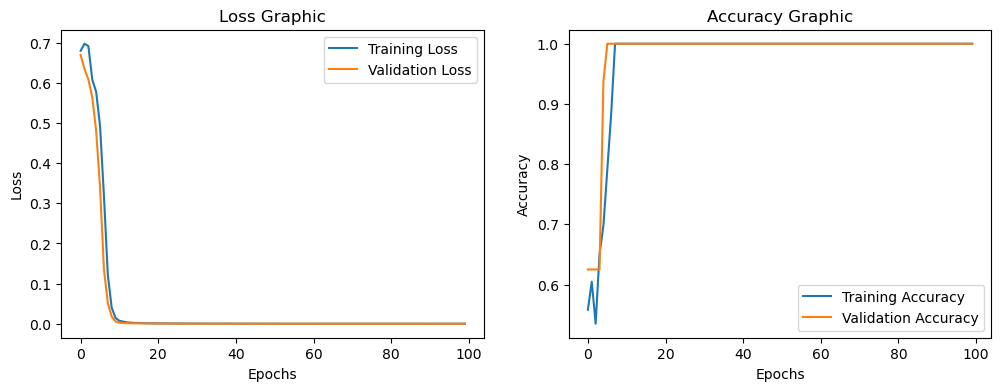

In [10]:
plot_training_history(history)

Validação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        10

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16


#########################################################

Teste:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Validação:


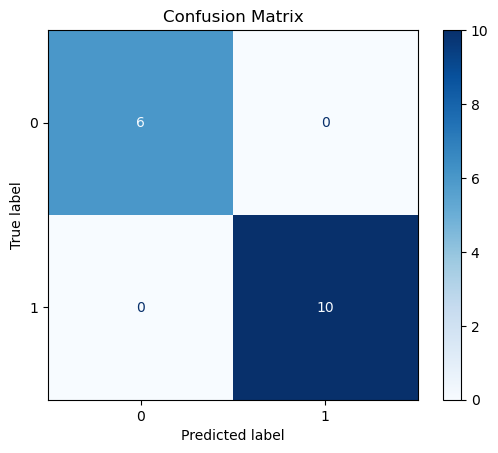

Teste:


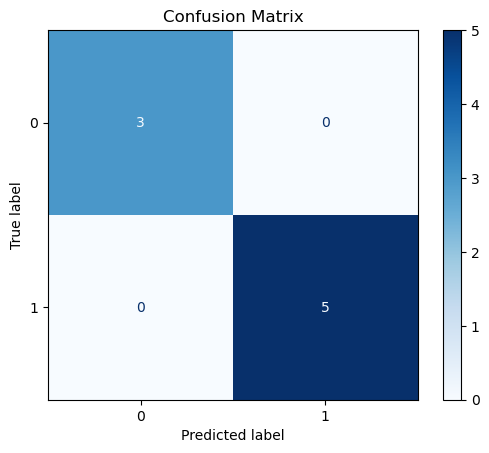

In [11]:
# Avaliar o modelo na validação e teste
y_pred_valid = (model.predict(val_dataset) > 0.5).astype(int)
y_pred_test = (model.predict(test_dataset) > 0.5).astype(int)

# Gerar o relatório de classificação
print("Validação:")
print(classification_report(val_labels, y_pred_valid))
print("\n#########################################################\n")
print("Teste:")
print(classification_report(test_labels, y_pred_test)) 

# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(val_labels, y_pred_valid)
print("Teste:")
plot_confusion_matrix(test_labels, y_pred_test)